In [3]:
import re
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import pickle
import pandas as pd 
import csv
from ete3 import Tree
from ete3 import NCBITaxa 
from Bio import SeqIO

In [4]:
## Install a local copy of the NCBI taxonomy database
ncbi = NCBITaxa()

## The first time you attempt to use NCBITaxa, ETE will detect that 
## your local database is empty and it will attempt to download the 
## latest NCBI taxonomy database (~300MB) and will store a parsed 
## version of it in your home directory: ~/.etetoolkit/taxa.sqlite. 


## To upgrade the database when previously installed:
ncbi.update_taxonomy_database() 


NCBI database not present yet (first time used?)
Done. Parsing...


Loading node names...
2110795 names loaded.
208594 synonyms loaded.
Loading nodes...
2110795 nodes loaded.
Linking nodes...
Tree is loaded.
Updating database: /home/adam/.etetoolkit/taxa.sqlite ...
 2110000 generating entries... nerating entries... 166000 generating entries...  generating entries...  generating entries... 

Inserting synonyms:       5000 


Uploading to /home/adam/.etetoolkit/taxa.sqlite



Inserting taxid merges:  25000  

Inserting taxids:       10000  

Inserting taxids:       2110000 

In [6]:
## parse a GenBank file, store the taxon identifiers in a dictionary
# taxDict = {}

# recs = [rec for rec in SeqIO.parse("viral.genomic.gbff", "genbank")]
## print(len(recs))
## 10544

## get taxids of RNA viruses
for rec in recs:
#     print(rec)
    for feature in rec.features:
        if 'source' in feature.type:
            taxid = ''.join(feature.qualifiers['db_xref'])
            taxid = re.sub(r'.*taxon:','',taxid)
    taxonomy = rec.annotations['taxonomy']  
    if ("ssRNA viruses" in taxonomy) or ("dsRNA viruses" in taxonomy):
        taxDict[rec.id] = taxid



In [43]:
taxID_set = set(taxDict.values())

## make a dictionary of all the taxon identifiers for each RNA viral family
## (keys = families; values = list of taxon identifiers)
rank2tax_dict = {}

for taxid in taxID_set:
    ## get lineage --> hierarchically sorted list of parent taxids.
    try:
        lineage = ncbi.get_lineage(taxid)   
    except:
        continue
    names = ncbi.get_taxid_translator(lineage)
    lineage2ranks = ncbi.get_rank(names)
    ranks2lineage = dict((rank, taxid) for (taxid, rank) in lineage2ranks.items())

    ranks = {'family_id': ranks2lineage.get('family')}
    if ranks is not None:
        for rank, id in ranks.items():
            if rank.split('_id')[0] == 'family' and str(id).isdigit():
                if id not in rank2tax_dict.keys():
                    rank2tax_dict[id] = []
                rank2tax_dict[id].append(taxid)

# print(len(rank2tax_dict))

## Dict of scientific names (instead of taxon identifier numbers)
RNAfamDict = {}
for family in rank2tax_dict.keys():
    taxList = rank2tax_dict[family]
    famname_scientific = (ncbi.get_taxid_translator([str(family)]))[family]
    taxDict_scientific = ncbi.get_taxid_translator(taxList)
    taxList_scientific = list(taxDict_scientific.values())
    if family not in RNAfamDict:
        RNAfamDict[famname_scientific] = taxList_scientific
#         print(f"{famname_scientific}")


## save a pickled version of the dict to file
with open("RNA.family.pickle", "wb") as handle:
    pickle.dump(RNAfamDict, handle, protocol = pickle.HIGHEST_PROTOCOL)


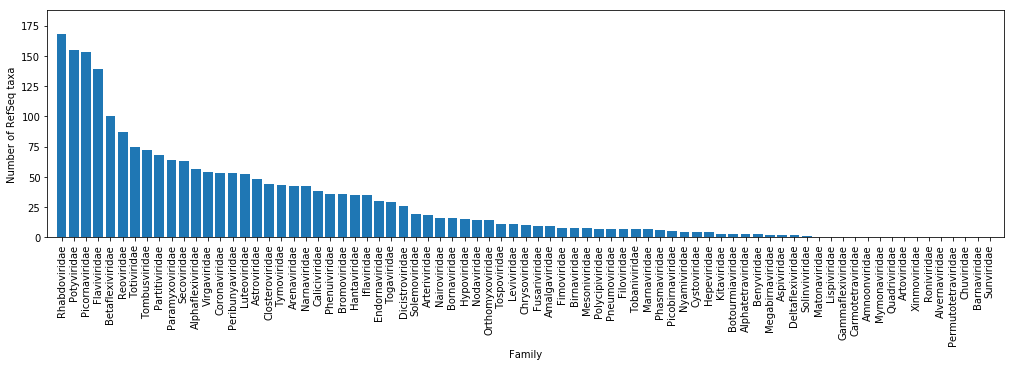

In [7]:
## load the dict from file
with open("RNA.family.pickle", "rb") as handle:
    RNAfamDict = pickle.load(handle)

## get taxon counts per family 
taxCounts = {k:sum(1 for x in v if x) for k,v in RNAfamDict.items()}
with open("RNA_virus_family_counts.tsv", "w") as fo:
    writer = csv.writer(fo, dialect="excel-tab")
    for key, value in taxCounts.items():
        writer.writerow((key, value))

## bar plot of the counts per family  
def barPlotFromDict(inDict, xlab, ylab, fname):
    sortedX = sorted(inDict, key=lambda k: inDict[k], reverse = True)
    sortedCounts = sorted(list(inDict.values()), reverse = True)
    x = np.arange(len(inDict))
    xlabs = [elem[:20] for elem in sortedX]
    fig, ax = plt.subplots(figsize = (14, 5))
    plt.bar(x, sortedCounts)
    plt.xticks(x, xlabs, rotation = 90)
    ymax = max(sortedCounts) + 20
    plt.ylim(0, ymax)
    plt.tight_layout()
    plt.margins(x = 0.01)
    ax.set_ylabel(ylab)
    ax.set_xlabel(xlab)
    plt.savefig(fname, bbox_inches='tight', dpi = 300)

## bar plot of counts by taxon
barPlotFromDict(
    taxCounts, 
    xlab = 'Family', ylab = 'Number of RefSeq taxa', 
    fname = 'RNA_family_counts.png'
)


In [9]:
## Parsing and viewing trees

## Koonin supplementary Data Set S2 = full tree of RdRps + RTs 
kooninTree = Tree("Data_Set_S2.nwk")
print(len(kooninTree))
# 4627

kooninNodes = kooninTree.get_leaves()
# print(kooninNodes)

## Koonin supplementary Data Set S4 = 
## representatives from Branch 1
kooninBranch1 = Tree("Data_Set_S4_Branch_1.nwk")
# print(len(kooninBranch1))
# 45

branch1Leaves = kooninBranch1.get_leaf_names()

## get the Branch 1 clade on the full tree
branch1_clade = kooninTree.get_common_ancestor(branch1Leaves)
# print(len(branch1_clade))
# 299

print(branch1_clade)

4627

            /-YP_009329842.1|Hubei_narna_like_virus_24
         /-|
        |  |   /-YP_009336767.1|Hubei_narna_like_virus_23
        |   \-|
        |     |   /-YP_009333146.1|Beihai_narna_like_virus_26
        |      \-|
        |         \-YP_009336749.1|Hubei_narna_like_virus_22
        |
        |                     /-ALD89118.1|Rhizoctonia_solani_mitovirus_13
        |                  /-|
        |                 |  |   /-YP_009182161.1|Botrytis_cinerea_mitovirus_3
        |                 |   \-|
        |                 |     |   /-ALM62240.1|Soybean_leaf_associated_mitovirus_5
        |                 |      \-|
        |                 |         \-YP_009272900.1|Fusarium_poae_mitovirus_3
        |                 |
        |               /-|      /-CAJ32466.1|Ophiostoma_mitovirus_1a
        |              |  |   /-|
        |              |  |  |  |   /-ALD89122.1|Rhizoctonia_solani_mitovirus_3
        |              |  |  |   \-|
        |              |  |  | 